# Simulation Analysis
Run 1

### 1. Import Packages
Here we will be using the reading and writing tools that come with the ParFlow tools package.  

In [2]:
import xarray as xr
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd

import parflow as pf
from parflow.tools.fs import get_absolute_path
from parflow.tools.io import write_pfb, read_pfb
from parflow import Run
import parflow.tools.hydrology as hydro

#setting the directory name that we will read our outputs from
run_name = 'spinup.wy2003' #'spinup.scaling.48_36' # 'spinup.scaling.9.70_54'#
pf_run_dir = '/glade/scratch/tijerina/CONUS2/spinup_WY2003/run_inputs/output-pf' #spinup_scaling/outputs_r1_0-25_4' #copy_spinup_scaling' #
clm_run_dir = '/glade/scratch/tijerina/CONUS2/spinup_WY2003/run_inputs/output-clm'
print(pf_run_dir)
print(clm_run_dir)

/glade/scratch/tijerina/CONUS2/spinup_WY2003/run_inputs/output-pf
/glade/scratch/tijerina/CONUS2/spinup_WY2003/run_inputs/output-clm


####  2. Read in the domain properties
First we will load the run from the pfidb file and get the properties using the [data_accessor](https://parflow.readthedocs.io/en/latest/tutorials/data_accessor.html?highlight=data_accessor) and by reading out the keys we need from the model object. 

In [5]:
run = Run.from_definition(f'{pf_run_dir}/{run_name}.pfidb')
data = run.data_accessor
nt = len(data.times)
nx = data.shape[2]
ny = data.shape[1]
nz = data.shape[0]
dx = data.dx
dy = data.dy
dz = data.dz

print(nt,nx,ny,nz,dx,dy,dz)

porosity = data.computed_porosity 
specific_storage = data.specific_storage 
#mannings = pf.read_pfb(f'{run_dir}/spinup.scaling.48_36.out.n.pfb') #run.Mannings.Geom.domain.Value
mannings = data.mannings

## remove input filenames for TopoSlopes to force the data accessor to read the output slopes
## this fixes a windows issue
run.TopoSlopesX.FileName = None
run.TopoSlopesY.FileName = None

slopex = data.slope_x 
slopey = data.slope_y 
mask = data.mask

# formatting the mask so that values outside the domain are NA and inside the domain are 1
# check with mask that has 0 and 1
nanmask=mask.copy()
#nanmask[nanmask == 0] = 'NaN'
nanmask[nanmask > 0] = 1

Solver: Field BinaryOutDir is not part of the expected schema <class 'parflow.tools.database.generated.Solver'>
Solver.OverlandKinematic: Field SeepageOne is not part of the expected schema <class 'parflow.tools.database.generated.OverlandKinematic'>
Solver.OverlandKinematic: Field SeepageTwo is not part of the expected schema <class 'parflow.tools.database.generated.OverlandKinematic'>
 => Error during CLM import - CLM specific key have been skipped
1 4442 3256 10 1000.0 1000.0 [2.0e+02 1.0e+02 5.0e+01 2.5e+01 1.0e+01 5.0e+00 1.0e+00 6.0e-01 3.0e-01
 1.0e-01]


In [6]:
nt

1

In [7]:
nanmask[9,2000:2005,2000:2005]

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [8]:
print(mannings.shape)

(1, 3256, 4442)


#### 4. Read the simulation output files

In [ ]:
#list all pressure files from outputs
lw_press_files = glob(f'{pf_run_dir}/{run_name}.out.press*.pfb')
#print(lw_press_files)
#read in all pressure files into a 3D NParray
pressure_arrays = pf.read_pfb_sequence(lw_press_files) * nanmask

#list all saturation files from outputs
lw_satur_files = glob(f'{pf_run_dir}/{run_name}.out.satur*.pfb')
#read in all pressure files into a 3D NParray
saturation_arrays = pf.read_pfb_sequence(lw_satur_files) * nanmask

#### 5. Calculate water balance
We will be using the hydrology tools to calculate the water balance. You can find more information on the tools [here](https://parflow.readthedocs.io/en/latest/tutorials/hydrology.html).

In [28]:
subsurface_storage = np.zeros(nt)
surface_storage = np.zeros(nt)
wtd = np.zeros((nt, ny, nx))
et = np.zeros(nt)
overland_flow = np.zeros((nt, ny, nx))
data.time = 0

for i, (pressure, saturation) in enumerate(zip(pressure_arrays, saturation_arrays)):
    subsurface_storage[i, ...] = np.sum(hydro.calculate_subsurface_storage(porosity, pressure, saturation, specific_storage, dx, dy, dz, mask = nanmask),axis=(0, 1, 2))
    # total surface storage for this time step is the summation of substorage surface across all x/y slices
    surface_storage[i, ...] = np.sum( hydro.calculate_surface_storage(pressure, dx, dy, mask = nanmask),axis=(0, 1))
    wtd[i, ...] = hydro.calculate_water_table_depth(pressure, saturation, dz)
    
    data.time = i
    if i != 0:
        if data.et is not None:
            # total ET for this time step is the summation of ET values across all x/y/z slices
            et[i, ...] = np.sum(hydro.calculate_evapotranspiration(data.et, dx, dy, dz, mask = nanmask),axis=(0, 1, 2))

 
    overland_flow[i, ...] = hydro.calculate_overland_flow_grid(pressure, slopex, slopey, mannings, dx, dy, mask = nanmask)

In [29]:
print(pressure_arrays.shape)
print(saturation_arrays.shape)

(25, 10, 3256, 4442)
(25, 10, 3256, 4442)


#### Look at some variable arrays

In [30]:
print(f'Overland Flow Shape: {overland_flow.shape}')
print(f'Max Overland Flow: {overland_flow.max()}')
print(f'Min Overland Flow: {overland_flow.min()}')
print(f'WTD Shape: {wtd.shape}')
print(f'Max WTD: {wtd.max()}')
print(f'Min WTD: {wtd.min()}')
print(f'Overland Flow at River: {overland_flow[24,4280:4285,2771:2776]}')
print(f'WTD somewhere: {wtd[5,2000:2005,2000:2005]}')
print(f'Surf Storage Shape: {surface_storage.shape}')
print(f'ET Shape: {et.shape}')

Overland Flow Shape: (97, 3256, 4442)
Max Overland Flow: 535534724.25735414
Min Overland Flow: 0.0
WTD Shape: (97, 3256, 4442)
Max WTD: 296.9230810296221
Min WTD: 0.0
Overland Flow at River: []
WTD somewhere: [[ 0.33586557  2.26945571  7.0481504   0.34063031  5.77088073]
 [ 5.34336019  6.03184128  7.53240192  0.33833538  9.9212282 ]
 [ 2.20643716 10.03533612  6.77141754  1.25731489  7.22419842]
 [ 7.02042731 16.68751701  8.3660533   7.10233193 13.20541879]
 [30.91019556 20.8748334   6.62334087  6.62887243 10.00695062]]
Surf Storage Shape: (97,)
ET Shape: (97,)


In [31]:
data.et.shape

(3256, 4442)

In [32]:
print(et)
print(subsurface_storage)
print(surface_storage)

[0.00000000e+00 2.98413102e+10 2.33665078e+10 2.00496813e+10
 1.66789837e+10 1.44173316e+10 1.30212353e+10 1.16575379e+10
 9.88918926e+09 8.70293622e+09 7.62928789e+09 7.31684669e+09
 7.48755371e+09 1.11313936e+10 3.09664930e+10 5.68247244e+10
 8.77567028e+10 1.13183627e+11 1.31485169e+11 1.38639817e+11
 1.31684141e+11 1.16682189e+11 9.36113487e+10 5.61540863e+10
 2.66740840e+10 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

#### Plot Static maps of the simulation outputs

(97, 3256, 4442)
(25, 10, 3256, 4442)


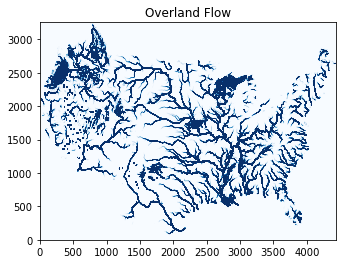

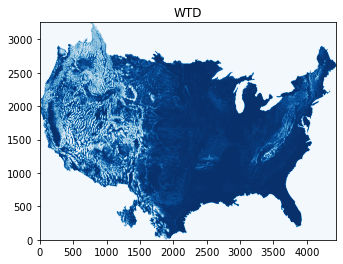

('eflx_lh_tot', 'eflx_lwrad_out', 'eflx_sh_tot', 'eflx_soil_grnd', 'qflx_evap_tot', 'qflx_evap_grnd', 'qflx_evap_soi', 'qflx_evap_veg', 'qflx_tran_veg', 'qflx_infl', 'swe_out', 't_grnd', 'qflx_qirr', 't_soil')


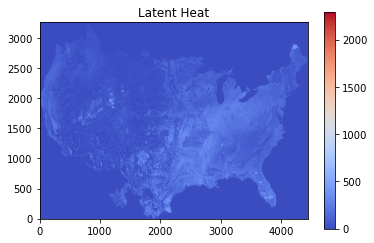

In [33]:
print(np.shape(overland_flow))
print(np.shape(pressure_arrays))

plt.imshow(overland_flow[20,:,:], cmap="Blues", origin='lower', vmin = 0, vmax = 500)
#plt.colorbar()
plt.title('Overland Flow')
plt.show()
plt.imshow(wtd[10,:,:], cmap="Blues_r", origin='lower')
#plt.colorbar()
plt.title('WTD')
plt.show()

#print out all CLM variables avilable
print(data.clm_output_variables)
# set timestep to visualize
data.time = 20
# fileter out inactive cells
LH_plot = np.where(data.clm_output(field='eflx_lh_tot') > -99, data.clm_output(field='eflx_lh_tot'), 0.)
im = plt.imshow(LH_plot, cmap="coolwarm", origin='lower')
#plt.show(im)
plt.title('Latent Heat')
plt.colorbar(im)

#### Plotting components of water balance

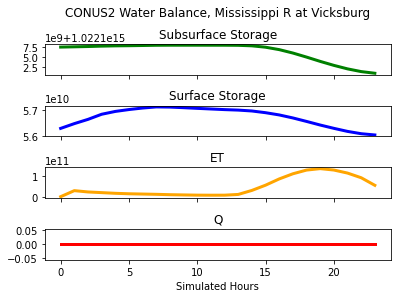

In [34]:
#plotting components of water balance
fig, axs = plt.subplots(4, sharex=True)
fig.suptitle('CONUS2 Water Balance, Mississippi R at Vicksburg')
axs[0].plot(subsurface_storage[0:24], linewidth=3, color = "green")
axs[0].set_title("Subsurface Storage")
axs[1].plot(surface_storage[0:24], linewidth=3, color = "blue")
axs[1].set_title("Surface Storage")
axs[2].plot(et[0:24], linewidth=3, color = "orange")
axs[2].set_title("ET")
axs[3].plot(overland_flow[0:24,2770, 847], linewidth=3, color = "red")
axs[3].set_title("Q")
plt.xlabel('Simulated Hours')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.85, 
                    wspace=0.7, 
                    hspace=1.0)
axs[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

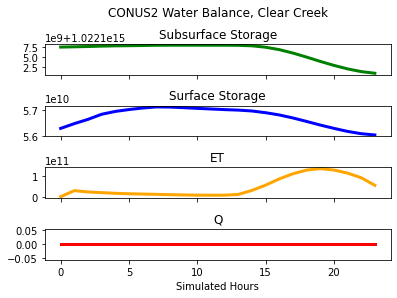

In [35]:
#plotting components of water balance
fig, axs = plt.subplots(4, sharex=True)
fig.suptitle('CONUS2 Water Balance, Clear Creek')
axs[0].plot(subsurface_storage[0:24], linewidth=3, color = "green")
axs[0].set_title("Subsurface Storage")
axs[1].plot(surface_storage[0:24], linewidth=3, color = "blue")
axs[1].set_title("Surface Storage")
axs[2].plot(et[0:24], linewidth=3, color = "orange")
axs[2].set_title("ET")
axs[3].plot(overland_flow[0:24,1528,1679], linewidth=3, color = "red")
axs[3].set_title("Q")
plt.xlabel('Simulated Hours')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.85, 
                    wspace=0.7, 
                    hspace=1.0)
axs[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

#### Save txt files of storage, et, overland flow

In [15]:
# save out 1D outputs to text files
np.savetxt(f'{run_dir}/water_balance/subsurface_storage_r1_test.txt', subsurface_storage[0:25], delimiter=",")
np.savetxt(f'{run_dir}/water_balance/surface_storage_r1_test.txt', surface_storage[0:25], delimiter=",")
np.savetxt(f'{run_dir}/water_balance/et_r1_test.txt', et[0:25], delimiter=",")

In [80]:
# save all 24 timesteps of overland flow to text files
# use zfill to fill 6 digits with leading zeros
for i in range(len(overland_flow[0:25])):
    np.savetxt(f'{run_dir}/water_balance/overland_flow_{str(i).zfill(6)}_r1_test.txt', overland_flow[i,:,:], delimiter=",") 

### Water Balance Calculations

#### 2. Normalize water balance quantities by active CONUS2 area using PFTools ET
Note 7/21 - This I'm not sure is correct. Current logic is that the PFTools outputs ET in a volume, so probably mm^3/s. Multiply this by 3600 s/h to get mm^3/h. Then divide by CONUS2 area, which is converted from km^2 to mm^2 (then you basically have mm^3/s * 1/mm^2). However, if you wanted to really make the units make sense, you would actually divide by 1e12 for km2 to mm2 (not 1e6, which is km to mm).

In [19]:
et_array = np.loadtxt(f'{run_dir}/water_balance/et_r1_test.txt') #[mm^3/s]
et_array = et_array/1000*3600#[mm^3/s] -> [mm^3/h]
et_array

array([0.00000000e+00, 1.22484588e+11, 9.61699526e+10, 8.23738216e+10,
       6.89568956e+10, 5.99610867e+10, 5.43418041e+10, 4.90278668e+10,
       4.20969602e+10, 3.74266838e+10, 3.33095819e+10, 3.18714515e+10,
       3.22849605e+10, 4.57108020e+10, 1.19837543e+11, 2.18832742e+11,
       3.37433235e+11, 4.35954273e+11, 5.07323379e+11, 5.35635385e+11,
       5.08285817e+11, 4.49602305e+11, 3.60521226e+11, 2.17826817e+11,
       1.04910548e+11])

In [ ]:
cumET = np.cumsum(et_array) # [mm^3/d]
conus_area = 7852823*1e6#km^2 to mm^2 ??? do you also multiply by number of layers because calculate_evapotranspiration() does nx*ny*nz, so *10 ??? 
normET = cumET[-1]/conus_area
print(f'ET over CONUS2 for 24 hour period: {round(normET, 5)} mm/d')

In [8]:
cumET

array([0.00000000e+00, 1.22484588e+14, 2.18654540e+14, 3.01028362e+14,
       3.69985257e+14, 4.29946344e+14, 4.84288148e+14, 5.33316015e+14,
       5.75412975e+14, 6.12839659e+14, 6.46149241e+14, 6.78020692e+14,
       7.10305653e+14, 7.56016455e+14, 8.75853998e+14, 1.09468674e+15,
       1.43211997e+15, 1.86807425e+15, 2.37539763e+15, 2.91103301e+15,
       3.41931883e+15, 3.86892113e+15, 4.22944236e+15, 4.44726918e+15,
       4.55217972e+15])

#### A. Check ET with clm_output 'qflx_evap_tot'

In [27]:
# 4: qflx_evap_tot for total evaporation [mm/s]
qflx_evap_CLM = np.zeros((24, ny, nx))
for i in range(24):    
    CLM_file = pf.read_pfb(f'{run_dir}/{run_name}.out.clm_output.{str(i+1).zfill(5)}.C.pfb')
    CLM_file[CLM_file<-9000] = 0 # set values outside of the domain to zero
    qflx_evap_CLM[i, ...] = CLM_file[4,...] # fill qflx_evap_CLM array by flagging the 4 position in the CLM file

(24, 3256, 4442)


Text(0.5, 1.0, 'net veg. evaporation and transpiration and soil evaporation (mms-1) for hour 1')

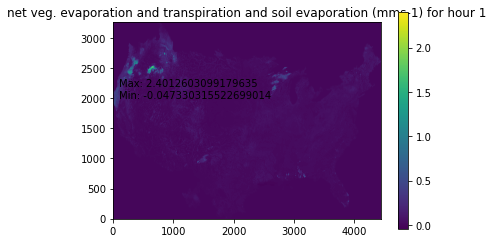

In [28]:
# convert ET from mm/s to mm/h
qflx_evap_CLM = qflx_evap_CLM*3600

# checking evap flux values and make sure that loop worked
print(qflx_evap_CLM.shape)
t = 0 #select timestep (hour) to plot
plt.imshow(qflx_evap_CLM[t,...], origin="lower")
plt.colorbar()
plt.annotate(f'Max: {qflx_evap_CLM[t].max()}', xy = (100,2200))
plt.annotate(f'Min: {qflx_evap_CLM[t].min()}', xy = (100,2000))
plt.title(f'net veg. evaporation and transpiration and soil evaporation (mms-1) for hour {t+1}')

array([ 312460.68240113,  245331.51173341,  210137.29995652,
        175910.4478849 ,  152961.95584328,  138627.05136176,
        125071.08865782,  107390.20469072,   95476.23426397,
         84973.42321606,   81304.72333709,   82359.5930958 ,
        116609.18880385,  305708.01744433,  558246.79063121,
        860799.06802499, 1112128.2462228 , 1294192.29367559,
       1366416.79787411, 1296647.49130757, 1146944.65560772,
        919697.00562556,  555680.65670463,  267628.94889041])

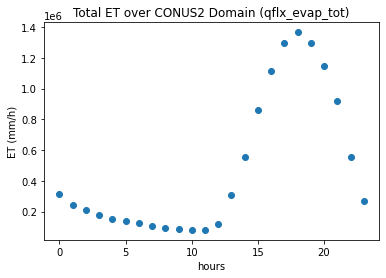

In [32]:
# sum all cells for every hour to get total hourly ET for entire CONUS2 domain
total_qflx_evap = np.zeros(24)

for i in range(24):
    total_qflx_evap[i] = np.sum(qflx_evap_CLM[i, ...])
plt.scatter(range(24),total_qflx_evap)
plt.xlabel("hours")
plt.ylabel("ET (mm/h)")
plt.title("Total ET over CONUS2 Domain (qflx_evap_tot)")
totalET